In [2]:
import glob 
import pandas as pd
import dask.dataframe as dd
import numpy as np
from tqdm import tqdm
import multiprocessing

In [3]:
cpu_count=multiprocessing.cpu_count()

In [4]:
tqdm.pandas()

## Jointure udis, prélèvements et résultats (data.gouv.fr)

In [5]:
## Create dataframe for dis_com_udi for all years
appended_dis_com_udi = []
for file in glob.glob('DIS_20*/DIS_COM_UDI_*'):
    data = pd.read_csv(file)
    # store DataFrame in list
    appended_dis_com_udi.append(data)
# see pd.concat documentation for more info
dis_com_udi = pd.concat(appended_dis_com_udi)
dis_com_udi.drop_duplicates(inplace=True)
ddis_com_udi=dd.from_pandas(dis_com_udi, npartitions=4*cpu_count)

In [6]:
ddis_com_udi.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07


In [7]:
def homog_udi(udi):
    while len(udi) < 9:
        udi= '0'+ udi
    return udi

def homog_comm(comm):
    while len(comm) < 5:
        comm= '0'+ comm
    return comm

def homog_dept(dept):
    while len(dept) < 3: 
        dept= '0' + dept
    return dept

def homog_prel(prel):
    while len(prel) < 11:
        prel= '0' + prel
    return prel


## 2016

In [8]:
dis_plv_2016 = pd.read_csv('DIS_2016/DIS_PLV_2016.txt')
dis_result_2016 = pd.read_csv('DIS_2016/DIS_RESULT_2016.txt', error_bad_lines=False)


## Homgénéiser les UDI et les communes
dis_plv_2016['cdreseau']=dis_plv_2016['cdreseau'].astype('str')

dis_plv_2016.drop(['inseecommuneprinc','nomcommuneprinc'],axis=1, inplace=True)

dis_plv_2016['cdreseau']=dis_plv_2016.progress_apply(lambda row: homog_udi(row['cdreseau']), axis=1)

## Homgénéiser les prélèvements

dis_plv_2016['referenceprel']=dis_plv_2016['referenceprel'].astype('str')
dis_result_2016['referenceprel']=dis_result_2016['referenceprel'].astype('str')

dis_plv_2016['referenceprel']=dis_plv_2016.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)
dis_result_2016['referenceprel']=dis_result_2016.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)

## Homogénéiser les départements 
dis_plv_2016['cddept']=dis_plv_2016['cddept'].astype('str')
dis_plv_2016['cddept']=dis_plv_2016.progress_apply(lambda row: homog_dept(row['cddept']), axis=1)

ddis_plv_2016=dd.from_pandas(dis_plv_2016, npartitions=4*cpu_count)
ddis_result_2016=dd.from_pandas(dis_result_2016, npartitions=4*cpu_count)

## jointure

djointure_2016=ddis_com_udi.merge(ddis_plv_2016, how='inner', on='cdreseau').merge(ddis_result_2016, how='inner', on='referenceprel')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,2,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 398877/398877 [00:02<00:00, 165480.83it/s]


In [9]:
djointure_2016.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,cddept_x,cdreseauamont,nomreseauamont,pourcentdebit,...,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite
0,01053,BOURG-EN-BRESSE,-,001001101,BOURG-EN-BRESSE - PERONNAS,2010-09-07,001,NaN,NaN,NaN,...,Aspect (qualitatif),NaN,O,L,Aspect normal,SANS OBJET,X,NaN,NaN,0.00
1,01053,BOURG-EN-BRESSE,-,001001101,BOURG-EN-BRESSE - PERONNAS,2010-09-07,001,NaN,NaN,NaN,...,Bact. et spores sulfito-rédu./100ml,NaN,N,L,<1,n/(100mL),226,NaN,<=0 n/(100mL),0.00
2,01053,BOURG-EN-BRESSE,-,001001101,BOURG-EN-BRESSE - PERONNAS,2010-09-07,001,NaN,NaN,NaN,...,Conductivité à 25°C,NaN,N,L,493,µS/cm,147,NaN,>=200 et <=1100 µS/cm,493.00
3,01053,BOURG-EN-BRESSE,-,001001101,BOURG-EN-BRESSE - PERONNAS,2010-09-07,001,NaN,NaN,NaN,...,Chlore libre,NaN,N,T,"0,20",mg(Cl2)/L,165,NaN,NaN,0.20
4,01053,BOURG-EN-BRESSE,-,001001101,BOURG-EN-BRESSE - PERONNAS,2010-09-07,001,NaN,NaN,NaN,...,Chlore total,NaN,N,T,"0,24",mg(Cl2)/L,165,NaN,NaN,0.24


## 2017

In [10]:
dis_plv_2017 = pd.read_csv('DIS_2017/DIS_PLV_2017.txt')
dis_result_2017 = pd.read_csv('DIS_2017/DIS_RESULT_2017.txt', error_bad_lines=False)


## Homgénéiser les UDI et les communes
dis_plv_2017['cdreseau']=dis_plv_2017['cdreseau'].astype('str')

dis_plv_2017.drop(['inseecommuneprinc','nomcommuneprinc'],axis=1, inplace=True)

dis_plv_2017['cdreseau']=dis_plv_2017.progress_apply(lambda row: homog_udi(row['cdreseau']), axis=1)

## Homgénéiser les prélèvements

dis_plv_2017['referenceprel']=dis_plv_2017['referenceprel'].astype('str')
dis_result_2017['referenceprel']=dis_result_2017['referenceprel'].astype('str')

dis_plv_2017['referenceprel']=dis_plv_2017.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)
dis_result_2017['referenceprel']=dis_result_2017.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)

## Homogénéiser les départements 
dis_plv_2017['cddept']=dis_plv_2017['cddept'].astype('str')
dis_plv_2017['cddept']=dis_plv_2017.progress_apply(lambda row: homog_dept(row['cddept']), axis=1)

ddis_plv_2017=dd.from_pandas(dis_plv_2017, npartitions=4*cpu_count)
ddis_result_2017=dd.from_pandas(dis_result_2017, npartitions=4*cpu_count)

## jointure
djointure_2017=ddis_com_udi.merge(ddis_plv_2017, how='inner', on='cdreseau').merge(ddis_result_2017, how='inner', on='referenceprel')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,2,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 407686/407686 [00:02<00:00, 166705.94it/s]


In [11]:
djointure_2017.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,cddept_x,cdreseauamont,nomreseauamont,pourcentdebit,...,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite
0,18176,PARASSY,-,018000605,PARASSY (BOURG+SMIRNE),2010-09-21,018,NaN,NaN,NaN,...,Aspect (qualitatif),NaN,O,L,Aspect normal,SANS OBJET,X,NaN,NaN,0.00
1,18176,PARASSY,-,018000605,PARASSY (BOURG+SMIRNE),2010-09-21,018,NaN,NaN,NaN,...,Bact. et spores sulfito-rédu./100ml,NaN,N,L,<1,n/(100mL),226,NaN,<=0 n/(100mL),0.00
2,18176,PARASSY,-,018000605,PARASSY (BOURG+SMIRNE),2010-09-21,018,NaN,NaN,NaN,...,Conductivité à 25°C,NaN,N,L,505,µS/cm,147,NaN,>=200 et <=1100 µS/cm,505.00
3,18176,PARASSY,-,018000605,PARASSY (BOURG+SMIRNE),2010-09-21,018,NaN,NaN,NaN,...,Chlore libre,NaN,N,T,"0,18",mg(Cl2)/L,165,NaN,NaN,0.18
4,18176,PARASSY,-,018000605,PARASSY (BOURG+SMIRNE),2010-09-21,018,NaN,NaN,NaN,...,Chlore total,NaN,N,T,N.M.,mg(Cl2)/L,165,NaN,NaN,NaN


## 2018

In [12]:
dis_plv_2018 = pd.read_csv('DIS_2018/DIS_PLV_2018.txt')
dis_result_2018 = pd.read_csv('DIS_2018/DIS_RESULT_2018.txt', error_bad_lines=False)


## Homgénéiser les UDI et les communes
dis_plv_2018['cdreseau']=dis_plv_2018['cdreseau'].astype('str')

dis_plv_2018.drop(['inseecommuneprinc','nomcommuneprinc'],axis=1, inplace=True)

dis_plv_2018['cdreseau']=dis_plv_2018.progress_apply(lambda row: homog_udi(row['cdreseau']), axis=1)

## Homgénéiser les prélèvements

dis_plv_2018['referenceprel']=dis_plv_2018['referenceprel'].astype('str')
dis_result_2018['referenceprel']=dis_result_2018['referenceprel'].astype('str')

dis_plv_2018['referenceprel']=dis_plv_2018.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)
dis_result_2018['referenceprel']=dis_result_2018.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)

## Homogénéiser les départements 
dis_plv_2018['cddept']=dis_plv_2018['cddept'].astype('str')
dis_plv_2018['cddept']=dis_plv_2018.progress_apply(lambda row: homog_dept(row['cddept']), axis=1)

ddis_plv_2018=dd.from_pandas(dis_plv_2018, npartitions=4*cpu_count)
ddis_result_2018=dd.from_pandas(dis_result_2018, npartitions=4*cpu_count)

## jointure
djointure_2018=ddis_com_udi.merge(ddis_plv_2018, how='inner', on='cdreseau').merge(ddis_result_2018, how='inner', on='referenceprel')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,2,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 411913/411913 [00:02<00:00, 162181.98it/s]


In [13]:
djointure_2018.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,cddept_x,cdreseauamont,nomreseauamont,pourcentdebit,...,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite
0,09206,MONTFERRIER,FREMIS,009001157,FREMIS,2010-08-03,009,NaN,NaN,NaN,...,Aspect (qualitatif),NaN,O,L,Aspect normal,SANS OBJET,X,NaN,NaN,0.0
1,09206,MONTFERRIER,FREMIS,009001157,FREMIS,2010-08-03,009,NaN,NaN,NaN,...,Bact. et spores sulfito-rédu./100ml,NaN,N,L,0,n/(100mL),226,NaN,<=0 n/(100mL),0.0
2,09206,MONTFERRIER,FREMIS,009001157,FREMIS,2010-08-03,009,NaN,NaN,NaN,...,Conductivité à 25°C,NaN,N,L,166,µS/cm,147,NaN,>=200 et <=1100 µS/cm,166.0
3,09206,MONTFERRIER,FREMIS,009001157,FREMIS,2010-08-03,009,NaN,NaN,NaN,...,Chlore libre,NaN,N,T,"<0,05",mg(Cl2)/L,165,NaN,NaN,0.0
4,09206,MONTFERRIER,FREMIS,009001157,FREMIS,2010-08-03,009,NaN,NaN,NaN,...,Chlore total,NaN,N,T,"<0,05",mg(Cl2)/L,165,NaN,NaN,0.0


## 2019

In [16]:
dis_plv_2019 = pd.read_csv('DIS_2019/DIS_PLV_2019.txt')
dis_result_2019 = pd.read_csv('DIS_2019/DIS_RESULT_2019.txt', error_bad_lines=False)


## Homgénéiser les UDI et les communes
dis_plv_2019['cdreseau']=dis_plv_2019['cdreseau'].astype('str')

dis_plv_2019.drop(['inseecommuneprinc','nomcommuneprinc'],axis=1, inplace=True)

dis_plv_2019['cdreseau']=dis_plv_2019.progress_apply(lambda row: homog_udi(row['cdreseau']), axis=1)

## Homgénéiser les prélèvements

dis_plv_2019['referenceprel']=dis_plv_2019['referenceprel'].astype('str')
dis_result_2019['referenceprel']=dis_result_2019['referenceprel'].astype('str')

dis_plv_2019['referenceprel']=dis_plv_2019.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)
dis_result_2019['referenceprel']=dis_result_2019.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)

## Homogénéiser les départements 
dis_plv_2019['cddept']=dis_plv_2019['cddept'].astype('str')
dis_plv_2019['cddept']=dis_plv_2019.progress_apply(lambda row: homog_dept(row['cddept']), axis=1)

ddis_plv_2019=dd.from_pandas(dis_plv_2019, npartitions=4*cpu_count)
ddis_result_2019=dd.from_pandas(dis_result_2019, npartitions=4*cpu_count)

## jointure
djointure_2019=ddis_com_udi.merge(ddis_plv_2019, how='inner', on='cdreseau').merge(ddis_result_2019, how='inner', on='referenceprel')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 429558/429558 [00:02<00:00, 161645.58it/s]


In [ ]:
djointure_2019.head()

## 2020 

In [17]:
dis_plv_2020 = pd.read_csv('DIS_2020/DIS_PLV_2020.txt')
dis_result_2020 = pd.read_csv('DIS_2020/DIS_RESULT_2020.txt', error_bad_lines=False)


## Homgénéiser les UDI et les communes
dis_plv_2020['cdreseau']=dis_plv_2020['cdreseau'].astype('str')

dis_plv_2020.drop(['inseecommuneprinc','nomcommuneprinc'],axis=1, inplace=True)

dis_plv_2020['cdreseau']=dis_plv_2020.progress_apply(lambda row: homog_udi(row['cdreseau']), axis=1)

## Homgénéiser les prélèvements

dis_plv_2020['referenceprel']=dis_plv_2020['referenceprel'].astype('str')
dis_result_2020['referenceprel']=dis_result_2020['referenceprel'].astype('str')

dis_plv_2020['referenceprel']=dis_plv_2020.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)
dis_result_2020['referenceprel']=dis_result_2020.progress_apply(lambda row: homog_prel(row['referenceprel']), axis=1)

## Homogénéiser les départements 
dis_plv_2020['cddept']=dis_plv_2020['cddept'].astype('str')
dis_plv_2020['cddept']=dis_plv_2020.progress_apply(lambda row: homog_dept(row['cddept']), axis=1)

ddis_plv_2020=dd.from_pandas(dis_plv_2020, npartitions=4*cpu_count)
ddis_result_2020=dd.from_pandas(dis_result_2020, npartitions=4*cpu_count)

## jointure
djointure_2020=ddis_com_udi.merge(ddis_plv_2020, how='inner', on='cdreseau').merge(ddis_result_2020, how='inner', on='referenceprel')

100%|██████████| 435831/435831 [00:02<00:00, 162859.03it/s]


In [ ]:
djointure_2020.head()

## Résultats commune par commune :

### Bretagne 2016 :

In [18]:
import geopandas as gpd

In [19]:
bretagne_2016=gpd.read_file('UDI_Bretagne/ars_r53_bretagne_udi_2016_jointure.json')

In [21]:
bretagne_2016.head()

,gid,c_gid,c_ins_code,cc_Fiche_infofacture,geometry
0,1,43,029000689,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((203774.200 6830915.200, 203803..."
1,2,44,029000801,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((167527.700 6787145.500, 167542..."
2,3,45,029000938,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((163388.100 6829120.400, 163425..."
3,4,46,029001514,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((195807.200 6797118.100, 195576..."
4,5,47,029000644,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((165982.600 6818224.100, 165997..."


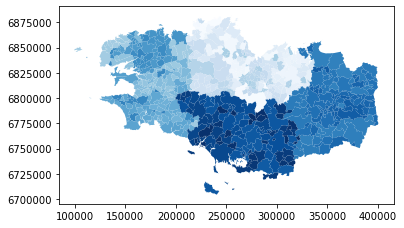

In [22]:
bretagne_2016.plot("c_ins_code", cmap="Blues")  

In [24]:
bretagne_map=gpd.read_file('UDI_Bretagne/bretagne.json')

In [25]:
bretagne_map.head()

,code,nom,geometry
0,56181,Port-Louis,"POLYGON ((-3.33971 47.71552, -3.34092 47.70870..."
1,22056,Évran,"POLYGON ((-1.93007 48.39433, -1.93847 48.39139..."
2,22199,Pleumeur-Gautier,"POLYGON ((-3.13750 48.78393, -3.15068 48.78381..."
3,22242,Plurien,"POLYGON ((-2.35379 48.60689, -2.35819 48.59873..."
4,22299,Saint-Hélen,"POLYGON ((-1.96153 48.48218, -1.94991 48.48560..."


In [28]:
## Les résultats des prélèvements en Bretagne sur data.gouv.fr
jointure_bretagne_2016=djointure_2016[djointure_2016['cddept_x'].isin(['022','029','035','056'])].compute()

In [32]:
## Les UDIs sur Atlasanté qui se trouvent sur data.gouv.fr
not_in_gov_data=bretagne_2016[~bretagne_2016['c_ins_code'].isin(jointure_bretagne_2016['cdreseau'])]
## Les UDIs sur Atlasanté qui ne se trouvent pas sur data.gouv.fr
in_gov_data=bretagne_2016[bretagne_2016['c_ins_code'].isin(jointure_bretagne_2016['cdreseau'])]

print("Le nombre d'UDIs sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: " + str (len(not_in_gov_data)))
print(not_in_gov_data['c_ins_code'].unique())
print("Le nombre d'UDIs sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: " + str (len(in_gov_data)))

Le nombre d'UDIs sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: 58
['029000689' '029000726' '029000633' '029000704' '029000770' '029000646'
 '029000773' '029000729' '029001488' '029000707' '029000712' '029000727'
 '029001108' '029001087' '029000930' '029000763' '029001091' '029000734'
 '029000968' '029000766' '029001092' '029000924' '029001086' '029001101'
 '029001141' '022000912' '022000844' '022000930' '022000932' '022000841'
 '022000964' '022000911' '022000963' '022000540' '022000596' '022001023'
 '022000842' '022000427' '022001000' '022003808' '035000803' '035001414'
 '035000282' '035000032' '035000484' '035003658' '035000483' '035003660'
 '035000462' '035003672' '035000407' '056003391' '056000426' '056000067'
 '056000256' '056001015' '035000802' '035003703']
Le nombre d'UDIs sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: 661


In [39]:
## Les UDIs sur data.gouv.fr qui ne sont pas sur Atlasanté
print("Le nombre d'UDIs sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: " + str (len(in_gov_not_in_atlasante['cdreseau'].unique())))
in_gov_not_in_atlasante['cdreseau'].unique()

Le nombre d'UDIs sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: 14


array(['022001614', '022000885', '022000282', '022000430', '022000884',
       '022000893', '022000519', '029000842', '029000841', '029000757',
       '029000572', '056004081', '056000519', '056004462'], dtype=object)

### Bretagne 2017

In [85]:
bretagne_2017=gpd.read_file('UDI_Bretagne/ars_r53_bretagne_udi_2016_jointure.json')

In [86]:
bretagne_2017.head()

,gid,c_gid,c_ins_code,cc_Fiche_infofacture,geometry
0,1,43,029000689,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((203774.200 6830915.200, 203803..."
1,2,44,029000801,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((167527.700 6787145.500, 167542..."
2,3,45,029000938,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((163388.100 6829120.400, 163425..."
3,4,46,029001514,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((195807.200 6797118.100, 195576..."
4,5,47,029000644,<a href=http://www.atlasante.fr/atlasante/info...,"MULTIPOLYGON (((165982.600 6818224.100, 165997..."


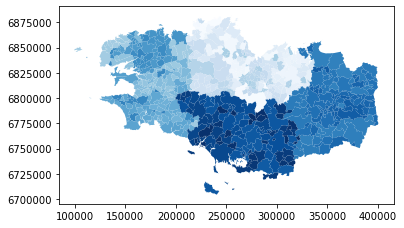

In [87]:
bretagne_2017.plot("c_ins_code", cmap="Blues")  

In [24]:
bretagne_map=gpd.read_file('UDI_Bretagne/bretagne.json')

In [25]:
bretagne_map.head()

,code,nom,geometry
0,56181,Port-Louis,"POLYGON ((-3.33971 47.71552, -3.34092 47.70870..."
1,22056,Évran,"POLYGON ((-1.93007 48.39433, -1.93847 48.39139..."
2,22199,Pleumeur-Gautier,"POLYGON ((-3.13750 48.78393, -3.15068 48.78381..."
3,22242,Plurien,"POLYGON ((-2.35379 48.60689, -2.35819 48.59873..."
4,22299,Saint-Hélen,"POLYGON ((-1.96153 48.48218, -1.94991 48.48560..."


In [88]:
## Les résultats des prélèvements en Bretagne sur data.gouv.fr
jointure_bretagne_2017=djointure_2017[djointure_2017['cddept_x'].isin(['022','029','035','056'])].compute()

In [90]:
## Les UDIs sur Atlasanté qui se trouvent sur data.gouv.fr
not_in_gov_data=bretagne_2017[~bretagne_2017['c_ins_code'].isin(jointure_bretagne_2017['cdreseau'])]
## Les UDIs sur Atlasanté qui ne se trouvent pas sur data.gouv.fr
in_gov_data=bretagne_2017[bretagne_2017['c_ins_code'].isin(jointure_bretagne_2017['cdreseau'])]

print("Le nombre d'UDIs sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: " + str (len(not_in_gov_data)))
print(not_in_gov_data['c_ins_code'].unique())
print("Le nombre d'UDIs sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: " + str (len(in_gov_data)))

Le nombre d'UDIs sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: 44
['029000689' '029000726' '029000633' '029000704' '029000770' '029000646'
 '029000773' '029000729' '029001488' '029000707' '029000712' '029000727'
 '029001108' '029001087' '029000763' '029001091' '029000734' '029000766'
 '029001092' '029000924' '029001086' '029001101' '029001141' '022000930'
 '022000932' '022000964' '022000963' '022000540' '022000596' '022001023'
 '022003808' '035000803' '035000282' '035000032' '035000484' '035003658'
 '035000483' '035003660' '035000462' '035003672' '035000407' '056003391'
 '056000426' '056000256']
Le nombre d'UDIs sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: 675


In [92]:
## Les UDIs sur data.gouv.fr qui ne sont pas sur Atlasanté
in_gov_not_in_atlasante=jointure_bretagne_2017[~jointure_bretagne_2017['cdreseau'].isin(bretagne_2017['c_ins_code'])]
print("Le nombre d'UDIs sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: " + str (len(in_gov_not_in_atlasante['cdreseau'].unique())))
in_gov_not_in_atlasante['cdreseau'].unique()

Le nombre d'UDIs sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: 14


array(['056004081', '056000519', '029000842', '029000572', '022000884',
       '022000430', '056004462', '022001614', '022000519', '022000885',
       '022000893', '029000841', '022000282', '029000757'], dtype=object)

### Val de Loire 2018 : 

In [49]:
vdl_2018=gpd.read_file('UDI_Val-de-Loire/ars_r24_udi_infofactures_2018_z.json')
vdl_2018.head()

,gid,objectid,udi_jointu,code,nom,lien_pdf,hyperlien,geometry
0,1,1,037000449,037000449,NEUVY LE ROI,<a href=http://www.atlasante.fr/atlasante/info...,http://www.atlasante.fr/atlasante/infofactures...,"MULTIPOLYGON (((518867.580 6730153.465, 519017..."
1,2,2,037000621,037000621,ST AUBIN LE DEPEINT,<a href=http://www.atlasante.fr/atlasante/info...,http://www.atlasante.fr/atlasante/infofactures...,"MULTIPOLYGON (((503589.758 6730230.060, 503609..."
2,3,3,037000444,037000444,NEUILLE PONT PIERRE,<a href=http://www.atlasante.fr/atlasante/info...,http://www.atlasante.fr/atlasante/infofactures...,"MULTIPOLYGON (((514220.651 6722867.166, 514235..."
3,4,4,037000144,037000144,CHATEAU LA VALLIERE,<a href=http://www.atlasante.fr/atlasante/info...,http://www.atlasante.fr/atlasante/infofactures...,"MULTIPOLYGON (((497178.064 6719780.574, 497257..."
4,5,5,037000601,037000601,SONZAY,<a href=http://www.atlasante.fr/atlasante/info...,http://www.atlasante.fr/atlasante/infofactures...,"MULTIPOLYGON (((507260.375 6719782.062, 507275..."


In [50]:
jointure_vdl_2018=djointure_2018[djointure_2018['cddept_x'].isin(['018','028','036','037','041','045'])].compute()

In [51]:
## Les UDIs sur Atlasanté qui se trouvent sur data.gouv.fr
not_in_gov_data=vdl_2018[~vdl_2018['udi_jointu'].isin(jointure_vdl_2018['cdreseau'])]
## Les UDIs sur Atlasanté qui ne se trouvent pas sur data.gouv.fr
in_gov_data=vdl_2018[vdl_2018['udi_jointu'].isin(jointure_vdl_2018['cdreseau'])]

print("Le nombre d'UDIs sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: " + str (len(not_in_gov_data)))
print(not_in_gov_data['udi_jointu'].unique())
print("Le nombre d'UDIs sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: " + str (len(in_gov_data)))

Le nombre d'UDIs sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: 51
['037000951' '036000058' '041000715' '041000703' '041000747' '041000719'
 '041000642' '041000487' '041000675' '041000742' '045000563' '045000475'
 '045000477' '045000474' '018000486' '018000529' '018000536' '018000598'
 '018000608' '018000640' '018000725' '018000731' '018000607' '018000579'
 '018000580' '018000729' '028001013' '028000572' '028001060' '028000583'
 '028000762' '028000800' '028001118' '028001138' '028001357' '028000880'
 '028001355' '028000922' '028000947' '028001399' '028001405' '028000871'
 '028000869' '028000872' '028000836' '028000834' '028001391' '028001009'
 '028001440' '028001292' '028003878']
Le nombre d'UDIs sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: 1044


In [52]:
## Les résultats des prélèvements en vdl sur data.gouv.fr

in_gov_not_in_atlasante=jointure_vdl_2018[~jointure_vdl_2018['cdreseau'].isin(vdl_2018['udi_jointu'])]

## Les UDIs sur data.gouv.fr qui ne sont pas sur Atlasanté
print("Le nombre d'UDIs sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: " + str (len(in_gov_not_in_atlasante['cdreseau'].unique())))
in_gov_not_in_atlasante['cdreseau'].unique()

Le nombre d'UDIs sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: 7


array(['018000488', '018000629', '018000676', '018000647', '037000181',
       '037000642', '018000660'], dtype=object)

### PACA 2018 : 

In [64]:
paca_2018=gpd.read_file('UDI_Paca/ars_r93_udi_infofacture.json')
paca_2018['c_insee_comm']=paca_2018['c_insee_comm'].astype('str')
paca_2018['c_insee_comm']=paca_2018.apply(lambda row: homog_comm(row['c_insee_comm']), axis=1)
paca_2018.head()

,gid,c_gid,c_objectid_1,c_départeme,c_udi_nom,c_nom_comm,c_insee_comm,c_udi_code,c_code_infof,geometry
0,1,1,1,05,None,ABRIES,05001,None,05001,"MULTIPOLYGON (((1010328.495 6414472.848, 10102..."
1,2,2,2,05,None,AIGUILLES,05003,None,05003,"MULTIPOLYGON (((1010659.997 6412146.157, 10106..."
2,3,3,3,05,None,ANCELLE,05004,None,05004,"MULTIPOLYGON (((959246.606 6394705.613, 959015..."
3,4,4,4,05,None,L'ARGENTIERE-LA-BESSEE,05006,None,05006,"MULTIPOLYGON (((982135.776 6413465.040, 981985..."
4,5,5,5,05,None,ARVIEUX,05007,None,05007,"MULTIPOLYGON (((997846.587 6409125.083, 997811..."


In [55]:
jointure_paca_2018=djointure_2018[djointure_2018['cddept_x'].isin(['004','005','006','013','083','084'])].compute()

In [76]:
## Les UDIs sur Atlasanté qui se trouvent sur data.gouv.fr
not_in_gov_data=paca_2018[~paca_2018['c_insee_comm'].isin(jointure_paca_2018['inseecommune'])]
## Les UDIs sur Atlasanté qui ne se trouvent pas sur data.gouv.fr
in_gov_data=paca_2018[paca_2018['c_insee_comm'].isin(jointure_paca_2018['inseecommune'])]

print("Le nombre de communes sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: " + str (len(not_in_gov_data['c_insee_comm'].unique())))
print(not_in_gov_data['c_insee_comm'].unique())
print("Le nombre de communes sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: " + str (len(in_gov_data['c_insee_comm'].unique())))

Le nombre de communes sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: 181
['05001' '05120' '04004' '04005' '04009' '04012' '04013' '04016' '04021'
 '04026' '04032' '04034' '04036' '04037' '04051' '04057' '04063' '04065'
 '04067' '04072' '04075' '04085' '04087' '04091' '04092' '04093' '04095'
 '04101' '04104' '04106' '04107' '04108' '04109' '04110' '04112' '04113'
 '04118' '04120' '04127' '04128' '04129' '04130' '04132' '04135' '04138'
 '04140' '04141' '04142' '04145' '04152' '04156' '04159' '04160' '04163'
 '04170' '04171' '04172' '04175' '04177' '04179' '04180' '04181' '04182'
 '04183' '04184' '04186' '04187' '04192' '04194' '04197' '04200' '04206'
 '04207' '04211' '04216' '04227' '04228' '04229' '04241' '04242' '04244'
 '04245' '04050' '04008' '04208' '04169' '04018' '04162' '04111' '04190'
 '04068' '04088' '04151' '04164' '04178' '04199' '04139' '04094' '04189'
 '04081' '04124' '04157' '04143' '04116' '04149' '04077' '04122' '04053'
 '04123' '04209' '04193' '

In [97]:
## Les résultats des prélèvements en paca sur data.gouv.fr

in_gov_not_in_atlasante=jointure_paca_2018[~jointure_paca_2018['inseecommune'].isin(paca_2018['c_insee_comm'])]

## Les UDIs sur data.gouv.fr qui ne sont pas sur Atlasanté
print("Le nombre de communes sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: " + str (len(in_gov_not_in_atlasante['inseecommune'].unique())))
in_gov_not_in_atlasante['inseecommune'].unique()

Le nombre de communes sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: 581


array(['06151', '13023', '13028', '13047', '06088', '06121', '06149',
       '06159', '06011', '06012', '06032', '06059', '06114', '06150',
       '06091', '06046', '06113', '06067', '06104', '06035', '06083',
       '06060', '06031', '83013', '83107', '06158', '13006', '13022',
       '13050', '06127', '83033', '83103', '83137', '84060', '84081',
       '84007', '13039', '06021', '06075', '06109', '06126', '06084',
       '06069', '06155', '06007', '06029', '06030', '06085', '06090',
       '06108', '06138', '83136', '83139', '13036', '06044', '06105',
       '06004', '06018', '06161', '06027', '06052', '06106', '06107',
       '06135', '06123', '06157', '06148', '06017', '06022', '06033',
       '06047', '06050', '06061', '06141', '06097', '06122', '06064',
       '06065', '06025', '06066', '06128', '83027', '83071', '13072',
       '83026', '83050', '83081', '83146', '83113', '06153', '06154',
       '06003', '06028', '06134', '06103', '83043', '83054', '83091',
       '84013', '840

### PACA 2020 :

In [70]:
paca_2020=gpd.read_file('UDI_Paca/ars_r93_udi_infofacture_2019.json')
paca_2020['insee_comm']=paca_2020['insee_comm'].astype('str')
paca_2020['insee_comm']=paca_2020.apply(lambda row: homog_comm(row['insee_comm']), axis=1)
paca_2020.head()

,gid,objectid_1,d__parteme,udi_nom,nom_comm,insee_comm,udi_code,code_infof,geometry
0,1,1,05,None,ABRIES,05001,None,05001,"MULTIPOLYGON (((1010328.495 6414472.848, 10102..."
1,2,2,05,None,AIGUILLES,05003,None,05003,"MULTIPOLYGON (((1010659.997 6412146.157, 10106..."
2,3,3,05,None,ANCELLE,05004,None,05004,"MULTIPOLYGON (((959246.606 6394705.613, 959015..."
3,4,4,05,None,L'ARGENTIERE-LA-BESSEE,05006,None,05006,"MULTIPOLYGON (((982135.776 6413465.040, 981985..."
4,5,5,05,None,ARVIEUX,05007,None,05007,"MULTIPOLYGON (((997846.587 6409125.083, 997811..."


In [71]:
jointure_paca_2020=djointure_2020[djointure_2020['cddept_x'].isin(['004','005','006','013','083','084'])].compute()

In [84]:
## Les UDIs sur Atlasanté qui se trouvent sur data.gouv.fr
not_in_gov_data=paca_2020[~paca_2020['insee_comm'].isin(jointure_paca_2020['inseecommune'])]
## Les UDIs sur Atlasanté qui ne se trouvent pas sur data.gouv.fr
in_gov_data=paca_2020[paca_2020['insee_comm'].isin(jointure_paca_2020['inseecommune'])]

print("Le nombre de communes sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: " + str (len(not_in_gov_data['insee_comm'].unique())))
print(not_in_gov_data['insee_comm'].unique())
print("Le nombre de communes sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: " + str (len(in_gov_data['insee_comm'].unique())))

Le nombre de communes sur AtlaSanté qui ne se trouvent pas sur les fichiers data.gouv.fr est: 4
['05120' '04100' '04198' '0None']
Le nombre de communes sur AtlaSanté qui se trouvent sur les fichiers data.gouv.fr est: 358


In [82]:
## Les résultats des prélèvements en paca sur data.gouv.fr

in_gov_not_in_atlasante=jointure_paca_2020[~jointure_paca_2020['inseecommune'].isin(paca_2020['insee_comm'])]

## Les UDIs sur data.gouv.fr qui ne sont pas sur Atlasanté
print("Le nombre de communes sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: " + str (len(in_gov_not_in_atlasante['inseecommune'].unique())))
in_gov_not_in_atlasante['inseecommune'].unique()

Le nombre de communes sur data.gouv.fr qui ne se trouvent pas sur Atlasanté est: 587


array(['06088', '06149', '06114', '06060', '06031', '06121', '06011',
       '06012', '06032', '06059', '06159', '06091', '06150', '06046',
       '06140', '13023', '13028', '13047', '06084', '06152', '06007',
       '06029', '06030', '06085', '06090', '06108', '06138', '06155',
       '06069', '06161', '06105', '06112', '06089', '06038', '06010',
       '13015', '13025', '13039', '83087', '83093', '83139', '13006',
       '13022', '13053', '83035', '83047', '83103', '83137', '83116',
       '83143', '84060', '84081', '84007', '06015', '06019', '06039',
       '06048', '06075', '06109', '06147', '06157', '06122', '06123',
       '06065', '06128', '06027', '13067', '13072', '83026', '83031',
       '83072', '83136', '83073', '83067', '83050', '83081', '83145',
       '83012', '84006', '84105', '84017', '06003', '06028', '06134',
       '06154', '06017', '06022', '06033', '06047', '06050', '06061',
       '06141', '06148', '06103', '13008', '13069', '13055', '83054',
       '84013', '840